# Recuperación ranqueada y vectorización de documentos

In [ ]:
import pandas as pd
import numpy as np
from typing import List
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import os
from typing import Dict, Any
import numpy as np
import seaborn as sns

In [85]:

PATH_TO_DATA = "data/"
PATH_TO_RESULTS = "results/"

docs_raw_path = f"{PATH_TO_DATA}docs-raw-texts/"
queries_raw_path = f"{PATH_TO_DATA}queries-raw-texts/"
judgments_file = f"{PATH_TO_DATA}relevance-judgments.tsv"
bsii_results_file = f"{PATH_TO_RESULTS}BSII-AND-queries_results.tsv"
rrdv_results_file = f"{PATH_TO_RESULTS}RRDV-consultas_resultados.tsv"




## Funciones necesarias del punto anterior

In [86]:
def precision_at_k(relevance_query: List[int], k: int) -> float:
    """
    Calcula la precision en el top-k de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
        k (int): Número de elementos a considerar en el top-k
    Returns:
        float: Precision en el top-k de la consulta
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo menor o igual al tamaño de la lista de relevancia")
    
    relevance_query = np.array(relevance_query)[:k]
    return np.mean(relevance_query)

In [87]:
def recall_at_k(relevance_query: List[int], number_relevant_docs: int,  k: int) -> float:
    """
    Calcula la recall en el top-k de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
        number_relevant_docs (int): Número total de documentos relevantes
        k (int): Número de elementos a considerar en el top-k
    Returns:
        float: Recall en el top-k de la consulta
    """
    if k <= 0:
        raise ValueError("k debe ser un entero positivo menor o igual al tamaño de la lista de relevancia")
    if number_relevant_docs <= 0:
        raise ValueError("El número de documentos relevantes debe ser un entero positivo")
        
    relevance_query = np.array(relevance_query)[:k]
    return np.sum(relevance_query) / number_relevant_docs
    

In [88]:
def average_precision(relevance_query: List[int]) -> float:
    """
    Calcula la precisión promedio de una consulta dada una lista de relevancia binaria
    Args:
        relevance_query (List[int]): Lista de relevancia binaria (1=relevante, 0=no relevante)
    Returns:
        float: Precisión promedio de la consulta
    """
    relevance_query = np.array(relevance_query)
    cumulative_precision = 0.0
    for i in range(len(relevance_query)):
        if relevance_query[i] == 1:
            cumulative_precision += precision_at_k(relevance_query, i + 1)
    if np.sum(relevance_query) == 0:
        return 0.0
    return cumulative_precision / np.sum(relevance_query)

In [89]:
def mean_average_precision(relevance_queries: List[List[int]]) -> float:
    """
    Calcula la precisión promedio de un conjunto de consultas
    Args:
        relevance_queries (List[List[int]]): Lista de listas de relevancia binaria
    Returns:
        float: Precisión promedio de todas las consultas
    """
    return np.mean([average_precision(query) for query in relevance_queries])

In [90]:
def dcg_at_k(relevance_scores: List[int], k: int) -> float:
    """
    Calcula el Discounted Cumulative Gain (DCG) en la posición k
    Args:
        relevance_scores (List[int]): Lista de relevancia (1=relevante, 0=no relevante)
        k (int): La posición hasta la cual calcular el DCG
    Returns:
        float: El valor del DCG en la posición k
    """
    relevance_scores = np.array(relevance_scores)[:k]
    positions = np.arange(1, len(relevance_scores) + 1)
    discounts = np.log2(np.maximum(positions, 2))
    dgc = np.sum(relevance_scores / discounts)
    return dgc

In [91]:
def ndcg_at_k(relevance_scores: List[int], k: int) -> float:
    """
    Calcula el Normalized Discounted Cumulative Gain (NDCG) en la posición k
    Args:
        relevance_scores (List[int]): Lista de relevancia (1=relevante, 0=no relevante)
        k (int): La posición hasta la cual calcular el NDCG
    Returns:
        float: El valor del NDCG en la posición k
    """
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = np.sort(relevance_scores)[::-1][:k]
    idcg = dcg_at_k(ideal_relevance, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

In [92]:
def normalize_text(text: str) -> str:
    """
    Normaliza el texto eliminando caracteres no deseados y convirtiendo a minúsculas.

    Args:
        text (str): El texto a normalizar.

    Returns:
        str: El texto normalizado.
    """
    text = text.strip().lower()
    text = re.sub(r"\s+", " ", text)  # Reemplaza múltiples espacios por uno solo
    text = re.sub(r'\[\d+\]', '', text)  # Elimina referencias numéricas
    return text

In [93]:
def tokenize_text(text: str) -> List[str]:
    """
    Tokeniza el texto en una lista de tokens utilizando expresiones regulares.

    Args:
        text (str): El texto a tokenizar.

    Returns:
        List[str]: La lista de tokens.
    """
    text = normalize_text(text)
    pattern = r'''(?x)
        (?:[A-Z]\.)+[A-Z]?                      # abreviaturas: U.S.A, U.S.A.
    | [A-Za-z]+(?:-[A-Za-z]+)*                  # palabras con guiones
    | [A-Za-z]+(?:'[A-Za-z]+)?                  # contracciones: don't, we're
    | \$?\d+(?:\.\d+)?%?                        # números simples
    | \.\.\.                                    # puntos suspensivos
    | [\[\].,;"'?():_`!-]                       # puntuación expandida
    '''
    tokens = nltk.regexp_tokenize(text, pattern)
    return tokens


In [94]:
def remove_stopwords(tokens: List[str]) -> List[str]:
    """
    Elimina las stopwords de una lista de tokens.

    Args:
        tokens (List[str]): La lista de tokens a procesar.

    Returns:
        List[str]: La lista de tokens sin stopwords.
    """
    stop_words = set(stopwords.words("english"))
    return [token for token in tokens if token not in stop_words]

In [95]:
def stem_tokens(tokens: List[str]) -> List[str]:
    """
    Aplica stemming a una lista de tokens.

    Args:
        tokens (List[str]): La lista de tokens a procesar.

    Returns:
        List[str]: La lista de tokens con stemming aplicado.
    """
    stemmer = SnowballStemmer("english")
    return [stemmer.stem(token) for token in tokens]


In [96]:
def preprocess_text(text: str) -> List[str]:
    """
    Preprocesa el texto aplicando normalización, tokenización, eliminación de stopwords y stemming.

    Args:
        text (str): El texto a preprocesar.

    Returns:
        List[str]: La lista de tokens preprocesados.
    """
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    tokens = stem_tokens(tokens)
    return tokens

In [97]:
from pathlib import Path
import xml.etree.ElementTree as ET

def load_naf_data(dir_naf:str) -> dict:
    """
    Carga los datos en formato NAF desde un directorio dado.
    Para cada documento se concatena el título y el texto en bruto.
    Luego de eso se procesa el texto, se tokeniza y se devuelve.

    Args:
        dir_naf (str): El directorio que contiene los archivos NAF.

    Returns:
        dict: Un diccionario con los IDs de los documentos como claves y listas de tokens como valores.
    """
    dirp = Path(dir_naf)
    out = {}
    for naf_path in sorted(dirp.glob("*.naf")):
        root = ET.parse(naf_path).getroot()
        public_id = root.find("./nafHeader/public").attrib["publicId"].strip()
        title = root.find("./nafHeader/fileDesc").attrib["title"].strip()
        raw_text = root.find("raw").text
        payload = raw_text[9:-3].strip()
        combinado = f"{title} {payload}"
        tokens = preprocess_text(combinado)
        out[public_id] = tokens

    return out

In [98]:
documents = load_naf_data(docs_raw_path)

In [99]:
def build_inverted_index(documents: dict) -> dict:
    """
    Construye un índice invertido a partir de los documentos tokenizados.

    Args:
        documents (dict): Un diccionario con los IDs de los documentos como claves y listas de tokens como valores.

    Returns:
        dict: Un índice invertido donde cada término tiene 'df' (document frequency) y 'postings' (lista ordenada de doc_ids).
    """
    inverted_index = {}
    
    for doc_id, tokens in documents.items():
        unique_tokens = set(tokens)
        for token in unique_tokens:
            if token not in inverted_index:
                inverted_index[token] = []
            inverted_index[token].append(doc_id)
    
    # Convertir a formato con df y postings ordenados
    for token in inverted_index:
        postings = sorted(inverted_index[token])  # Ordenar posting list
        inverted_index[token] = {
            'docfreq': len(postings),                  # Document frequency
            'postings': postings                  # Posting list ordenada
        }
    
    return inverted_index

In [100]:
inverted_index = build_inverted_index(documents)

## Cálculo TF-IDF

Para el cálculo de TF-IDF, es necesario calcular la frecuencia de términos (TF) y la frecuencia de documentos inversa (IDF).


In [ ]:
def create_tfidf_vector(tokens: List[str], inverted_index: dict, total_docs: int) -> Dict[str, float]:
    """
    Crea un vector TF-IDF para un documento o consulta específica utilizando 
    la fórmula de ponderación logarítmica.


    Args:
        tokens: Lista de tokens del documento/consulta 
        inverted_index: Índice invertido con estructura {'term': {'df': int, 'postings': list}}
        total_docs: Número total de documentos en la colección
    
    Returns:
        Dict con términos como claves y valores TF-IDF como valores
    """
    if not tokens:
        return {}
    
    # Calcular Term Frequency
    term_counts = {}
    for token in tokens:
        term_counts[token] = term_counts.get(token, 0) + 1
    tfidf_vector = {}
    
    # Calcular TF-IDF solo para términos presentes
    for term, count in term_counts.items():
        if term in inverted_index:  
            tf_soft = np.log10(count + 1)
            idf = np.log10(total_docs / inverted_index[term]['docfreq'])
            tfidf_vector[term] = tf_soft * idf
        # Términos no en índice tienen TF-IDF = 0 (se omiten)
    
    return tfidf_vector

In [102]:
print(len(documents))

331


In [103]:
print(create_tfidf_vector(documents.get("d006", []), inverted_index, len(documents)))

{'eugenio': np.float64(1.726560436579374), 'beltrami': np.float64(2.8867227498625643), 'non-euclidian': np.float64(1.4277907382552266), 'geometri': np.float64(1.4493424982382466), 'eltrami': np.float64(0.758543810040283), '.': np.float64(0.0), '(': np.float64(0.05082688261488847), '1835': np.float64(0.70539290946943), '-': np.float64(0.14678176857950007), '1900': np.float64(0.41352489242969576), ')': np.float64(0.05082688261488847), 'novemb': np.float64(0.2419753309465222), '16': np.float64(0.2762756977973888), ',': np.float64(0.0), 'italian': np.float64(0.5193294189522057), 'mathematician': np.float64(0.23704132403246678), 'born': np.float64(0.04452339645434377), 'notabl': np.float64(0.3229058341402392), 'work': np.float64(0.08440183874298862), 'concern': np.float64(0.2900500749824635), 'differenti': np.float64(0.44505337454260085), 'mathemat': np.float64(0.4960419692573516), 'physic': np.float64(0.30217867225670025), 'note': np.float64(0.3014255653031476), 'especi': np.float64(0.2049

In [104]:
def cosine_similarity_sparse(vec1: Dict[str, float], vec2: Dict[str, float]) -> float:
    """
    Calcula la similaridad coseno entre dos vectores esparsos TF-IDF.
    
    Ventajas de la implementación esparsa:
    
    Esta función aprovecha la representación esparsa para optimizar el cálculo 
    de similaridad. El producto punto se computa únicamente sobre términos 
    presentes en ambos vectores (intersección de vocabularios), evitando 
    iteraciones innecesarias sobre términos ausentes que contribuirían con 0.
    
    
    El cálculo de las normas considera todos los términos no nulos de cada 
    vector, manteniendo la equivalencia matemática con la implementación densa.

    Args:
        vec1, vec2: Vectores TF-IDF representados como diccionarios donde 
                   las claves son términos y los valores son pesos TF-IDF
    
    Returns:
        float: Valor de similaridad coseno en el rango [0, 1], donde 0 indica 
               vectores ortogonales (sin términos comunes) y 1 indica vectores 
               idénticos en dirección
    """
    if not vec1 or not vec2:
        return 0.0
    
    # Términos comunes para producto punto
    common_terms = set(vec1.keys()) & set(vec2.keys())
    
    if not common_terms:
        return 0.0
    
    # Producto punto solo sobre términos comunes
    dot_product = sum(vec1[term] * vec2[term] for term in common_terms)
    
    # Normas euclidianas de cada vector
    norm1 = np.sqrt(sum(value ** 2 for value in vec1.values()))
    norm2 = np.sqrt(sum(value ** 2 for value in vec2.values()))
    
    if norm1 == 0 or norm2 == 0:
        return 0.0
    
    return dot_product / (norm1 * norm2)

In [105]:
vec_1 = create_tfidf_vector(documents.get("d006", []), inverted_index, len(documents))
vec_2 = create_tfidf_vector(documents.get("d017", []), inverted_index, len(documents))

print(cosine_similarity_sparse(vec_1, vec_2))

0.04053375195343071


In [ ]:
def process_ranked_queries(inverted_index: dict, processed_documents: dict, queries_folder: str, output_file: str):
    """
    Procesa todas las consultas con ranking TF-IDF y genera archivo de resultados

    Args:
        inverted_index: Índice invertido de la colección de documentos
        processed_documents: Documentos procesados con sus tokens
        queries_folder: Carpeta que contiene las consultas en formato NAF
        output_file: Archivo donde se guardarán los resultados

    Returns:
        None
    """
    
    total_docs = len(processed_documents)
    
    with open(output_file, 'w') as f:
        # Procesar archivos en orden
        query_files = sorted([file for file in os.listdir(queries_folder) if file.endswith('.naf')])
        
        for query_file in query_files:

            tree = ET.parse(os.path.join(queries_folder, query_file))
            query_text = tree.find('.//raw').text.strip()
            query_id = tree.find('.//public').get('publicId')
            
            query_tokens = preprocess_text(query_text)
            
            # Crear vector TF-IDF de la consulta
            query_vector = create_tfidf_vector(query_tokens, inverted_index, total_docs)
            
            if not query_vector:
                f.write(f"{query_id}\n")
                continue
            
            # Calcular similaridad con todos los documentos
            similarities = []
            for doc_id, doc_tokens in processed_documents.items():
                doc_vector = create_tfidf_vector(doc_tokens, inverted_index, total_docs)
                
                if doc_vector: 
                    similarity = cosine_similarity_sparse(query_vector, doc_vector)
                    if similarity > 0:
                        similarities.append((doc_id, similarity))
            
            # Ordenar por similaridad descendente
            similarities.sort(key=lambda x: x[1], reverse=True)
            
            # Escribir resultado en formato TSV
            if similarities:
                result_pairs = [f"{doc_id}:{sim:.4f}" for doc_id, sim in similarities]
                f.write(f"{query_id}\t{','.join(result_pairs)}\n")
            else:
                f.write(f"{query_id}\n")

In [107]:
process_ranked_queries(inverted_index, documents, queries_raw_path, rrdv_results_file)

In [ ]:
def create_binary_relevance_list(retrieved_docs: List[str], relevant_docs: Dict[str, int]) -> List[int]:
    """
    Convierte lista de docs recuperados a vector binario
    1 si el doc es relevante (está en relevance judgments), 0 si no

    Args:
        retrieved_docs: Lista de documentos recuperados
        relevant_docs: Diccionario de documentos relevantes con sus grados

    Returns:
        Lista de enteros (0 o 1) indicando relevancia
    """
    return [1 if doc_id in relevant_docs else 0 for doc_id in retrieved_docs]

def create_graded_relevance_list(retrieved_docs: List[str], relevant_docs: Dict[str, int]) -> List[int]:
    """
    Convierte lista de docs recuperados a vector con grados de relevancia
    Usa el grado del relevance judgment, 0 si no está

    Args:
        retrieved_docs: Lista de documentos recuperados
        relevant_docs: Diccionario de documentos relevantes con sus grados

    Returns:
        Lista de enteros (0 o 1) indicando relevancia
    """
    return [1 if doc_id in relevant_docs else 0 for doc_id in retrieved_docs]

def create_graded_relevance_list(retrieved_docs: List[str], relevant_docs: Dict[str, int]) -> List[int]:
    """
    Convierte lista de docs recuperados a vector con grados de relevancia
    Usa el grado del relevance judgment, 0 si no está

    Args:
        retrieved_docs: Lista de documentos recuperados
        relevant_docs: Diccionario de documentos relevantes con sus grados

    Returns:
        Lista de enteros con los grados de relevancia
    """
    return [relevant_docs.get(doc_id, 0) for doc_id in retrieved_docs]

def load_relevance_judgments(file_path: str) -> Dict[str, Dict[str, int]]:
    """
    Carga relevance judgments del archivo TSV

    Args:
        file_path: Ruta al archivo TSV

    Returns:
        Dict[str, Dict[str, int]]: Mapa de relevancia
    """
    relevance_data = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            query_id = parts[0]
            
            doc_relevances = {}
            if len(parts) > 1:  # Si hay documentos relevantes
                doc_pairs = parts[1].split(',')
                for pair in doc_pairs:
                    doc_id, grade = pair.split(':')
                    doc_relevances[doc_id] = int(grade)
            
            relevance_data[query_id] = doc_relevances
    
    return relevance_data

def load_tfidf_results(file_path: str) -> Dict[str, List[str]]:
    """
    Carga resultados TF-IDF del archivo
    
    Args:
        file_path: Ruta al archivo de resultados TF-IDF

    Returns:
        Dict[str, List[str]]: Mapa de resultados TF-IDF
    """
    results = {}
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            query_id = parts[0]
            
            doc_list = []
            if len(parts) > 1:  # Si hay resultados
                doc_pairs = parts[1].split(',')
                for pair in doc_pairs:
                    doc_id = pair.split(':')[0]  # Solo el doc_id, ignorar similaridad
                    doc_list.append(doc_id)
            
            results[query_id] = doc_list
    
    return results

In [ ]:
def evaluate_tfidf_system(
    tfidf_results_file: str,
    relevance_judgments_file: str
):
    """
    Evalúa sistema TF-IDF calculando P@M, R@M, NDCG@M por consulta y MAP global


    Args:
    tfidf_results_file: Ruta al archivo de resultados TF-IDF
    relevance_judgments_file: Ruta al archivo de juicios de relevancia
    output_file: Ruta al archivo de salida para los resultados de evaluación
    """
    
    # 1. Cargar datos
    relevance_data = load_relevance_judgments(relevance_judgments_file)
    tfidf_results = load_tfidf_results(tfidf_results_file)
    
    query_evaluations = {}
    average_precisions = []
    
    # 2. Evaluar cada consulta
    for query_id, relevant_docs in relevance_data.items():
        M = len(relevant_docs)  # Número de docs relevantes para esta consulta
        
        retrieved_docs = tfidf_results.get(query_id, [])
        
        binary_relevance = create_binary_relevance_list(retrieved_docs, relevant_docs)
        graded_relevance = create_graded_relevance_list(retrieved_docs, relevant_docs)
        
        # Calcular métricas
        precision_m = precision_at_k(binary_relevance, M)
        recall_m = recall_at_k(binary_relevance, M, M)  # M docs relevantes totales
        ndcg_m = ndcg_at_k(graded_relevance, M)
        avg_precision = average_precision(binary_relevance)
        
        query_evaluations[query_id] = {
            'precision_m': precision_m,
            'recall_m': recall_m, 
            'ndcg_m': ndcg_m,
            'average_precision': avg_precision
        }
        
        average_precisions.append(avg_precision)
    
    # 3. Calcular MAP
    map_score = sum(average_precisions) / len(average_precisions) if average_precisions else 0.0

    # Mostrar resultados
    print("Resultados de evaluación:")
    for query_id, metrics in query_evaluations.items():
        print(f"Consulta {query_id}:")
        for metric_name, value in metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    print(f"MAP: {map_score:.4f}")


In [111]:
evaluate_tfidf_system(
    tfidf_results_file=rrdv_results_file,
    relevance_judgments_file=judgments_file
)

Resultados de evaluación:
Consulta q01:
  precision_m: 0.3333
  recall_m: 0.3333
  ndcg_m: 0.2015
  average_precision: 0.4778
Consulta q02:
  precision_m: 0.5455
  recall_m: 0.5455
  ndcg_m: 0.5715
  average_precision: 0.6541
Consulta q03:
  precision_m: 1.0000
  recall_m: 1.0000
  ndcg_m: 0.9947
  average_precision: 1.0000
Consulta q04:
  precision_m: 0.7143
  recall_m: 0.7143
  ndcg_m: 0.7520
  average_precision: 0.8444
Consulta q06:
  precision_m: 0.6667
  recall_m: 0.6667
  ndcg_m: 0.8054
  average_precision: 0.8552
Consulta q07:
  precision_m: 0.2500
  recall_m: 0.2500
  ndcg_m: 0.4131
  average_precision: 0.2157
Consulta q08:
  precision_m: 0.7500
  recall_m: 0.7500
  ndcg_m: 0.8879
  average_precision: 0.8491
Consulta q09:
  precision_m: 0.8333
  recall_m: 0.8333
  ndcg_m: 0.8879
  average_precision: 0.9762
Consulta q10:
  precision_m: 0.3750
  recall_m: 0.3750
  ndcg_m: 0.4189
  average_precision: 0.3948
Consulta q12:
  precision_m: 1.0000
  recall_m: 1.0000
  ndcg_m: 0.9584
  

d:\Deep Learning\NLP\.venv\Lib\site-packages\seaborn\_statistics.py:32: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.stats import gaussian_kde


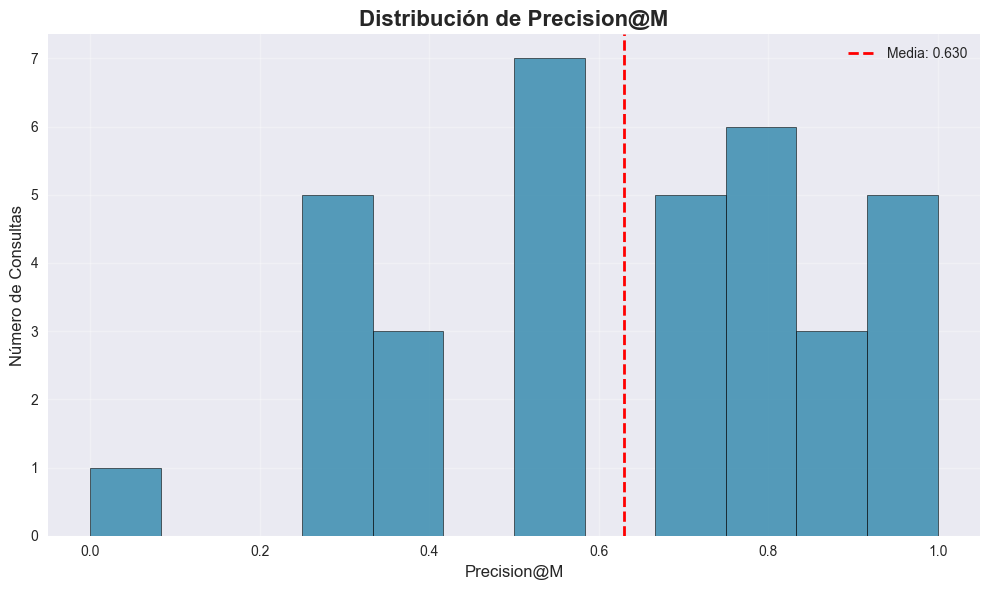

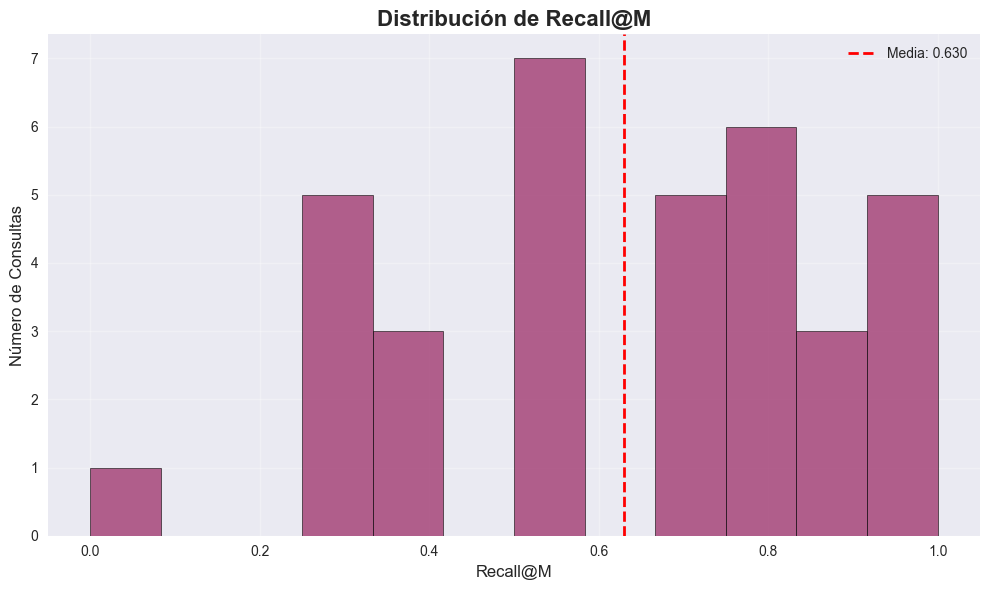

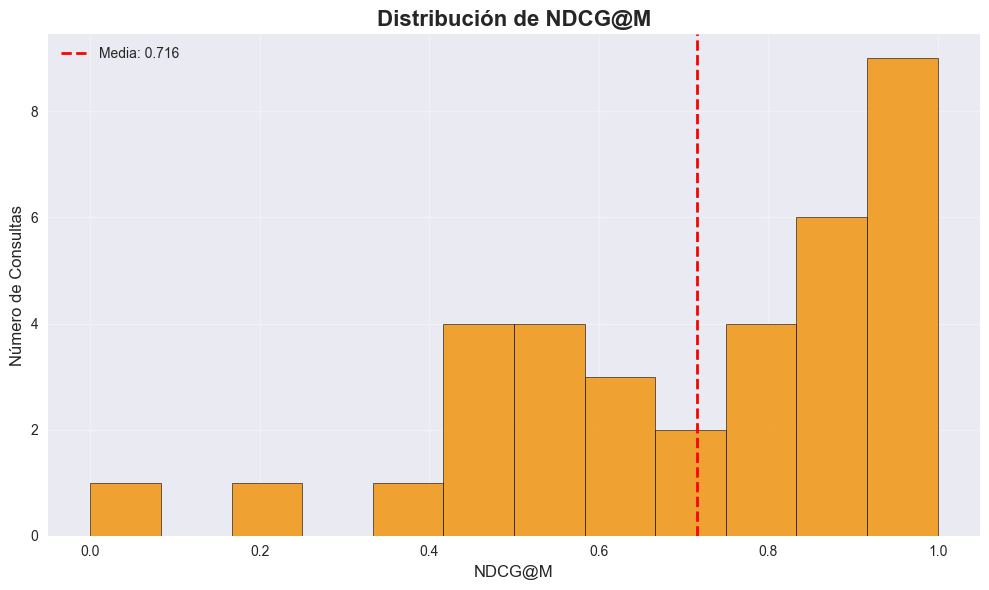

C:\Users\user\AppData\Local\Temp\ipykernel_40688\3226755010.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)


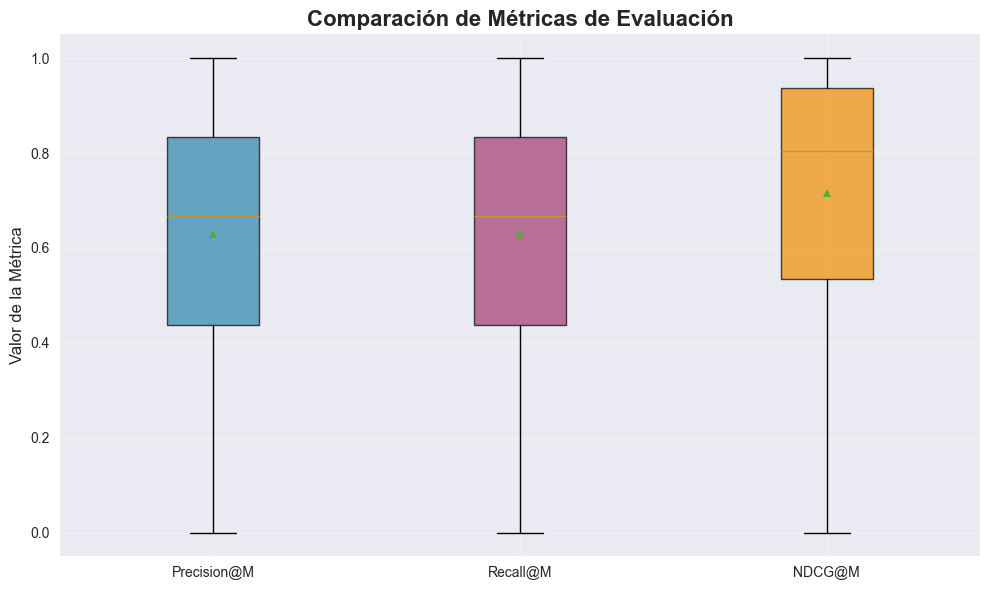

In [ ]:

# Configuración de estilo
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Datos
precision_values = [0.3333, 0.5455, 1.0000, 0.7143, 0.6667, 0.2500, 0.7500, 0.8333, 0.3750, 1.0000, 0.8000, 0.5833, 0.5000, 0.7500, 0.8571, 0.5000, 0.5714, 0.2500, 0.0000, 0.5000, 1.0000, 0.3750, 0.6667, 0.8333, 1.0000, 1.0000, 0.7000, 0.6667, 0.3750, 0.8889, 0.8571, 0.3333, 0.5000, 0.7500, 0.3333]

recall_values = [0.3333, 0.5455, 1.0000, 0.7143, 0.6667, 0.2500, 0.7500, 0.8333, 0.3750, 1.0000, 0.8000, 0.5833, 0.5000, 0.7500, 0.8571, 0.5000, 0.5714, 0.2500, 0.0000, 0.5000, 1.0000, 0.3750, 0.6667, 0.8333, 1.0000, 1.0000, 0.7000, 0.6667, 0.3750, 0.8889, 0.8571, 0.3333, 0.5000, 0.7500, 0.3333]

ndcg_values = [0.2015, 0.5715, 0.9947, 0.7520, 0.8054, 0.4131, 0.8879, 0.8879, 0.4189, 0.9584, 0.8327, 0.4582, 0.6000, 1.0000, 0.9161, 1.0000, 0.6874, 0.6037, 0.0000, 0.6747, 1.0000, 0.5298, 0.8087, 0.9793, 0.9948, 1.0000, 0.5005, 1.0000, 0.4182, 0.8554, 0.8720, 0.6052, 0.5405, 0.8842, 0.4204]

# Gráfica 1: Precision@M
plt.figure(figsize=(10, 6))
plt.hist(precision_values, bins=12, alpha=0.8, color='#2E86AB', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(precision_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(precision_values):.3f}')
plt.title('Distribución de Precision@M', fontsize=16, fontweight='bold')
plt.xlabel('Precision@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 2: Recall@M  
plt.figure(figsize=(10, 6))
plt.hist(recall_values, bins=12, alpha=0.8, color='#A23B72', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(recall_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(recall_values):.3f}')
plt.title('Distribución de Recall@M', fontsize=16, fontweight='bold')
plt.xlabel('Recall@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 3: NDCG@M
plt.figure(figsize=(10, 6))
plt.hist(ndcg_values, bins=12, alpha=0.8, color='#F18F01', edgecolor='black', linewidth=0.5)
plt.axvline(np.mean(ndcg_values), color='red', linestyle='--', linewidth=2, label=f'Media: {np.mean(ndcg_values):.3f}')
plt.title('Distribución de NDCG@M', fontsize=16, fontweight='bold')
plt.xlabel('NDCG@M', fontsize=12)
plt.ylabel('Número de Consultas', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfica 4: Boxplot comparativo
plt.figure(figsize=(10, 6))
data = [precision_values, recall_values, ndcg_values]
labels = ['Precision@M', 'Recall@M', 'NDCG@M']
colors = ['#2E86AB', '#A23B72', '#F18F01']

box = plt.boxplot(data, labels=labels, patch_artist=True, showmeans=True)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Comparación de Métricas de Evaluación', fontsize=16, fontweight='bold')
plt.ylabel('Valor de la Métrica', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()